In [ ]:
import sys
sys.path.append('src/')

import matplotlib.pyplot as plt
import numpy as np

from WADParser import open_wad_file
from WADViewer import WadViewer
from mus2mid import Mus2Mid
from WADPlayer import MIDIPlayer

### WADParser
The WAD parser can be started by using open_wad_file with a path to an existing wad.
It should then open it and parse the different lumps detected inside:

In [2]:
wad = open_wad_file('WADs/DOOM.WAD')

2025-04-16 21:57:56.252 | INFO     | WADParser:__init__:37 - Found a DOOM IWAD.
2025-04-16 21:57:56.257 | INFO     | WADParser:_parse_lumps:121 - Found 124 duplicated lumps in this IWAD.
2025-04-16 21:57:56.258 | INFO     | WADParser:_get_palette:150 - Palette extracted.
2025-04-16 21:57:56.258 | INFO     | WADParser:_parse_things:163 - DOOM THINGS loaded.
2025-04-16 21:57:56.352 | INFO     | WADParser:_parse_by_markers:193 - Found 107 FLATS between F_START and F_END in this WAD.
2025-04-16 21:57:56.352 | INFO     | WADParser:_parse_by_markers:193 - Found 764 SPRITES between S_START and S_END in this WAD.
2025-04-16 21:57:56.386 | INFO     | WADParser:_gather_textures:336 - Found 286 textures in 2 texture lumps.
2025-04-16 21:57:56.387 | INFO     | WADParser:_gather_musics:346 - Found 45 music lumps.


For convenience, the names of the lumps detected as _flats_, _sprites_ or _musics_ are grouped in the corresponding attributes:

In [3]:
wad.flats[:5], wad.sprites[:5], wad.musics[:5]

(['FLOOR7_2', 'FLOOR5_2', 'FLAT5_4', 'BLOOD3', 'FLAT23'],
 ['TROOF1', 'SARGD4D6', 'CYBRD1', 'SMGTD0', 'SARGE3'],
 ['D_E1M1', 'D_E1M2', 'D_E1M3', 'D_E1M4', 'D_E1M5'])

However, as maps are a group of multiple lumps, the attributes _maps_ is a dict containing the parsed maps attributes. 'block', 'two-sided' are the corresponding walls, 'things' shows the different things and their coordinates, etc... 

In [4]:
wad.maps['E1M1'].keys()

dict_keys(['block', 'two-sided', 'secret', 'special', 'things', 'metadata'])

In a similar way, the _textures_ attribute is a dict containing all information needed to build the corresponding texture:

In [21]:
list(wad.textures.keys())[:5]

['AASTINKY', 'BIGDOOR1', 'BIGDOOR2', 'BIGDOOR4', 'BRNBIGC']

For example:

In [6]:
wad.textures['AASTINKY']

{'width': 24,
 'height': 72,
 'patches': [('WALL00_3', 0, 0), ('WALL00_3', 12, -6)]}

In a similar manner, sprites are grouped into spritesheets, grouping every sprites from a monser, player, object, etc... Example with _HEAD_ (representing the cacodemon):

In [7]:
wad.spritesheets['HEAD'][:5]

['HEADA1', 'HEADA2A8', 'HEADA3A7', 'HEADA4A6', 'HEADA5']

### WadViewer

We can initialize a WadViewer class with the parsed Wad object to use all the drawing methods contained into the WadViewer. However, remember that the WAD format accepts two different kinds of image format: _patches_ store data by columns and accepts 'holes' when _flats_ are simple rectangular images. The user needs to know what kind of image they are expecting.
For example, the title screen in Doom is called "TITLEPIC" and is a _patch_ image. But the title screen in Heretic or Hexen is called "TITLE" and is actually a _flat_ image.

In [8]:
viewer = WadViewer(wad)

We can now use the drawing methods of the viewer. If used by default, it will return a matplotlib figure:

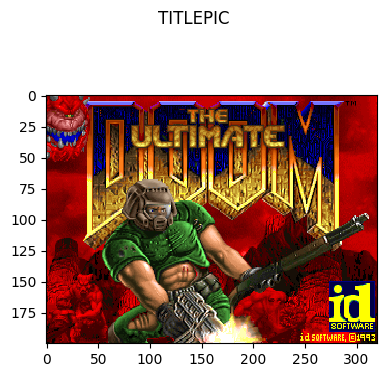

In [9]:
fig = viewer.draw_patch("TITLEPIC")

However, we can use a predefined Matplotlib figure and axes object to generate an image of any size:

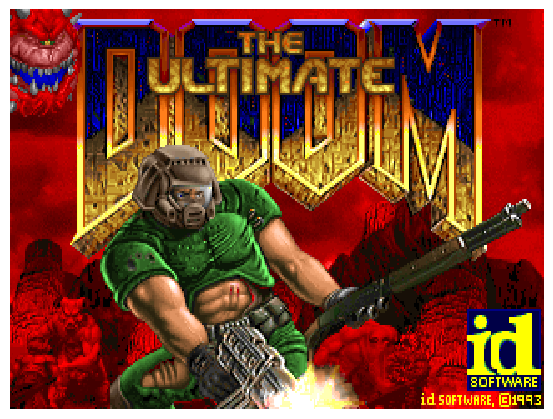

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6.4, 4))

fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.axis('off')

# If specified, the viewer will use this previously defined ax object.
viewer.draw_patch("TITLEPIC", ax=ax)

fig.tight_layout(pad=0)

This allows to easily display multiple elements in a single image. For example, we can display random sprites from the previously parsed list of sprites:

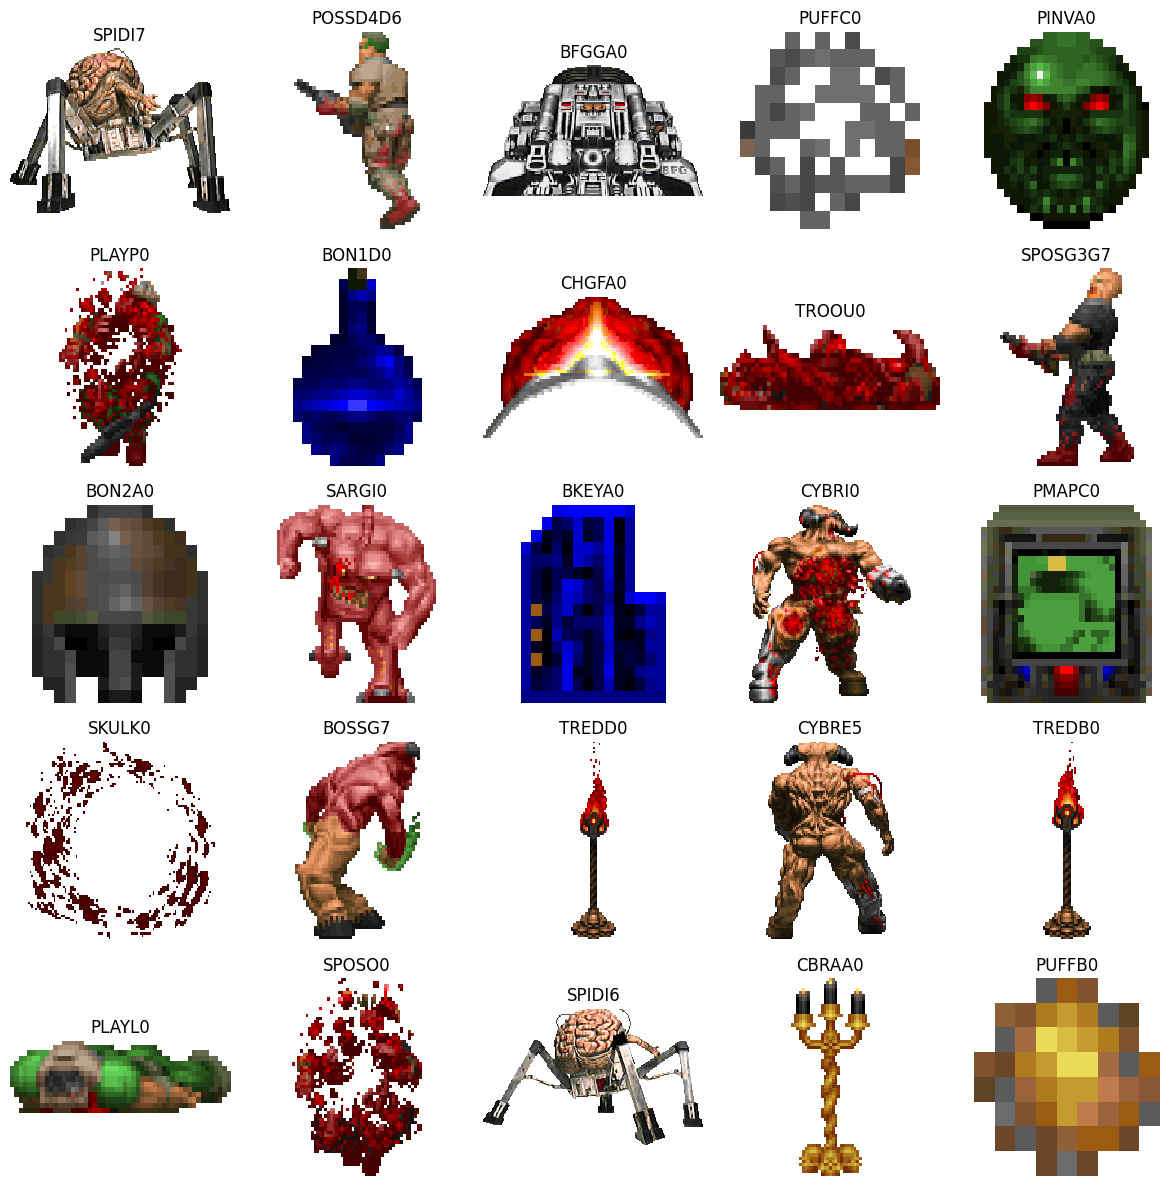

In [11]:
n_sprites = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

selected_sprites = np.random.choice(wad.sprites, size=n_sprites, replace=False)

for i, sprite_name in enumerate(selected_sprites):

    viewer.draw_patch(sprite_name, ax=ax[i])
    ax[i].set_title(sprite_name)
    ax[i].axis('off')

fig.tight_layout(pad=1.2)

Or create a single spritesheet containing all the images of a single monster:

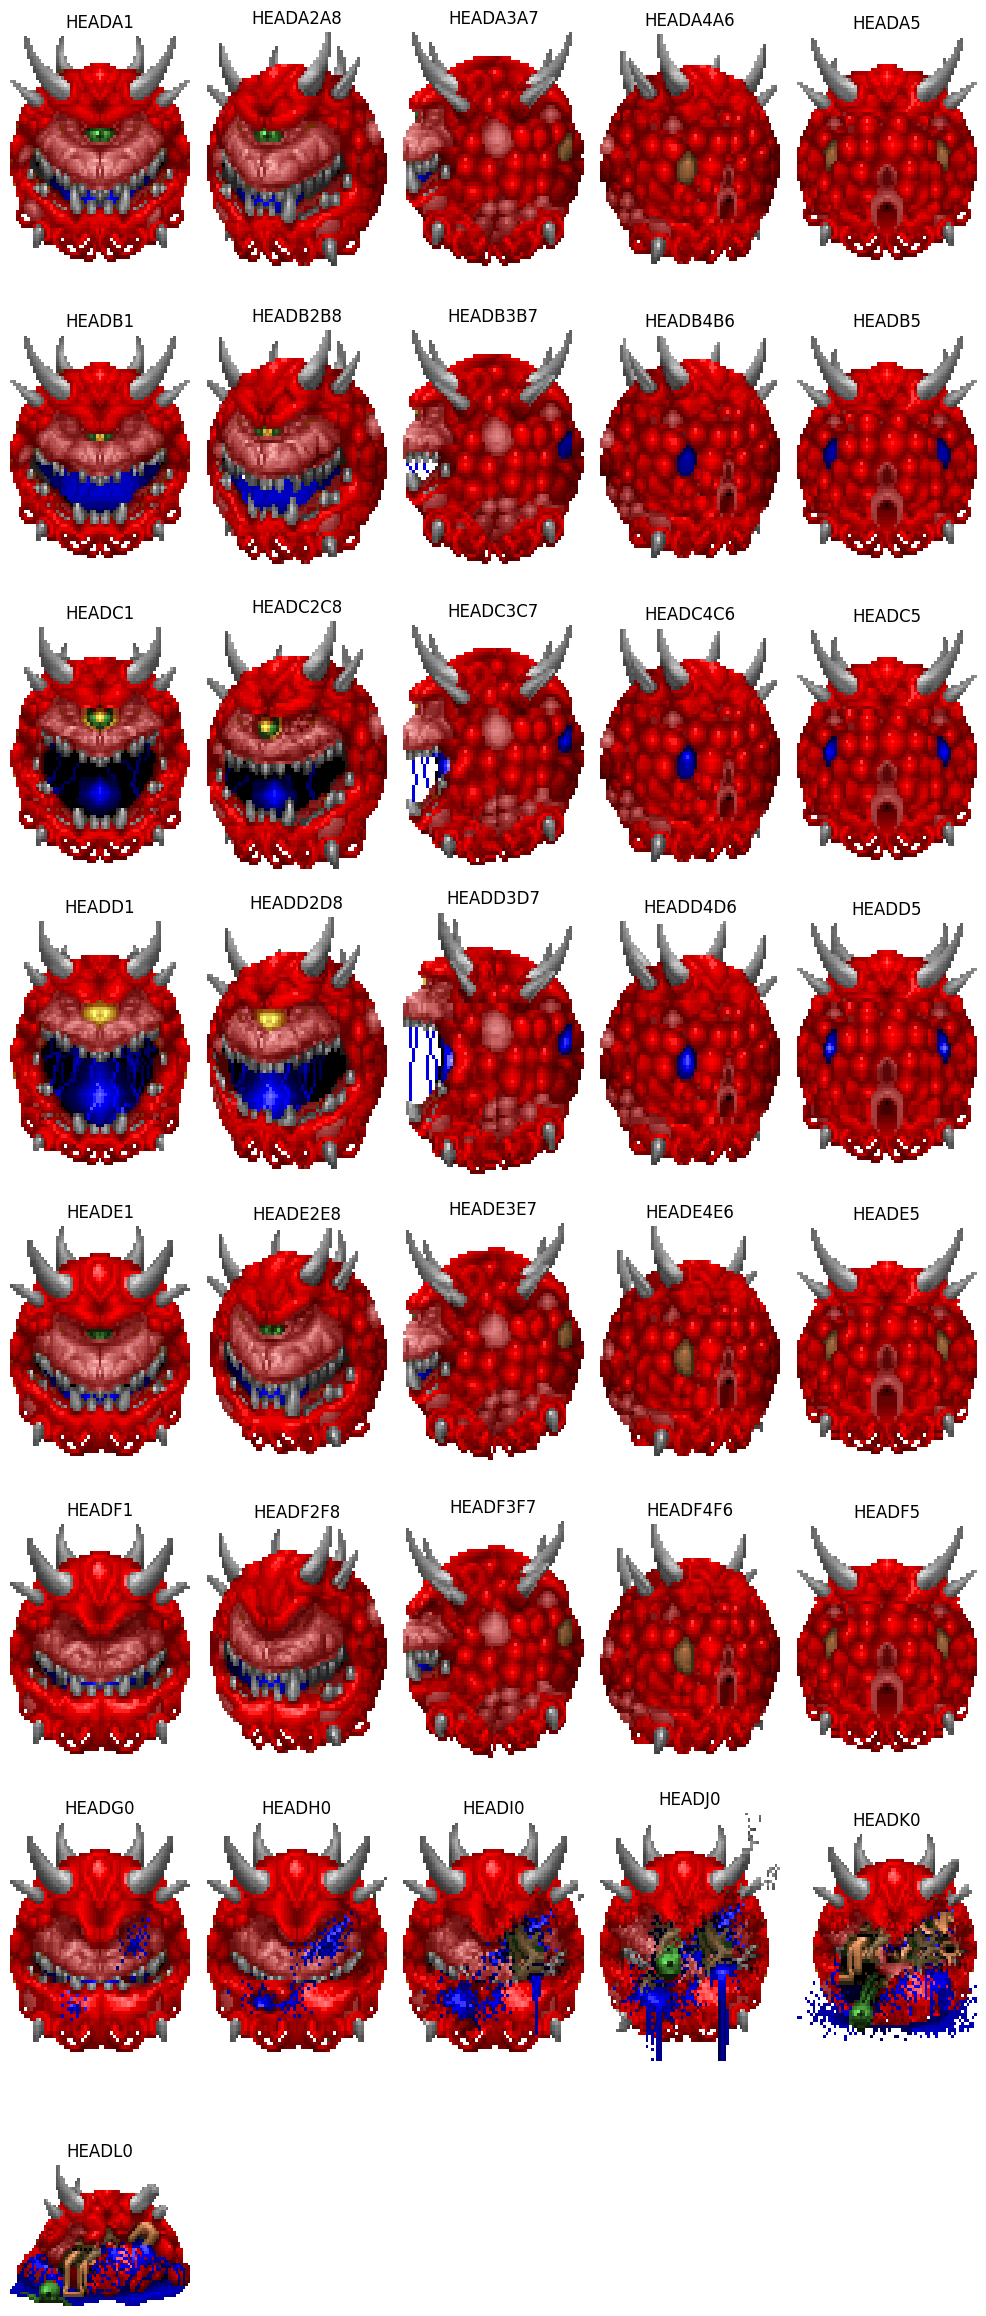

In [12]:
# Let's display the cacodemon!
sprite_name = 'HEAD'

sprite_list = wad.spritesheets[sprite_name]
ncols = 5
nrows = int(np.ceil(len(sprite_list) / ncols))

fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10, 3*nrows))
ax = ax.ravel()

for i, name in enumerate(sprite_list):
    
    viewer.draw_patch(name, ax=ax[i])
    ax[i].set_title(name)
    ax[i].axis('off')

[ax[i].set_visible(False) for i in range(len(sprite_list), len(ax))]
fig.tight_layout(pad=1.2)

In a  similar way, we can display many flats into a single image, for example:

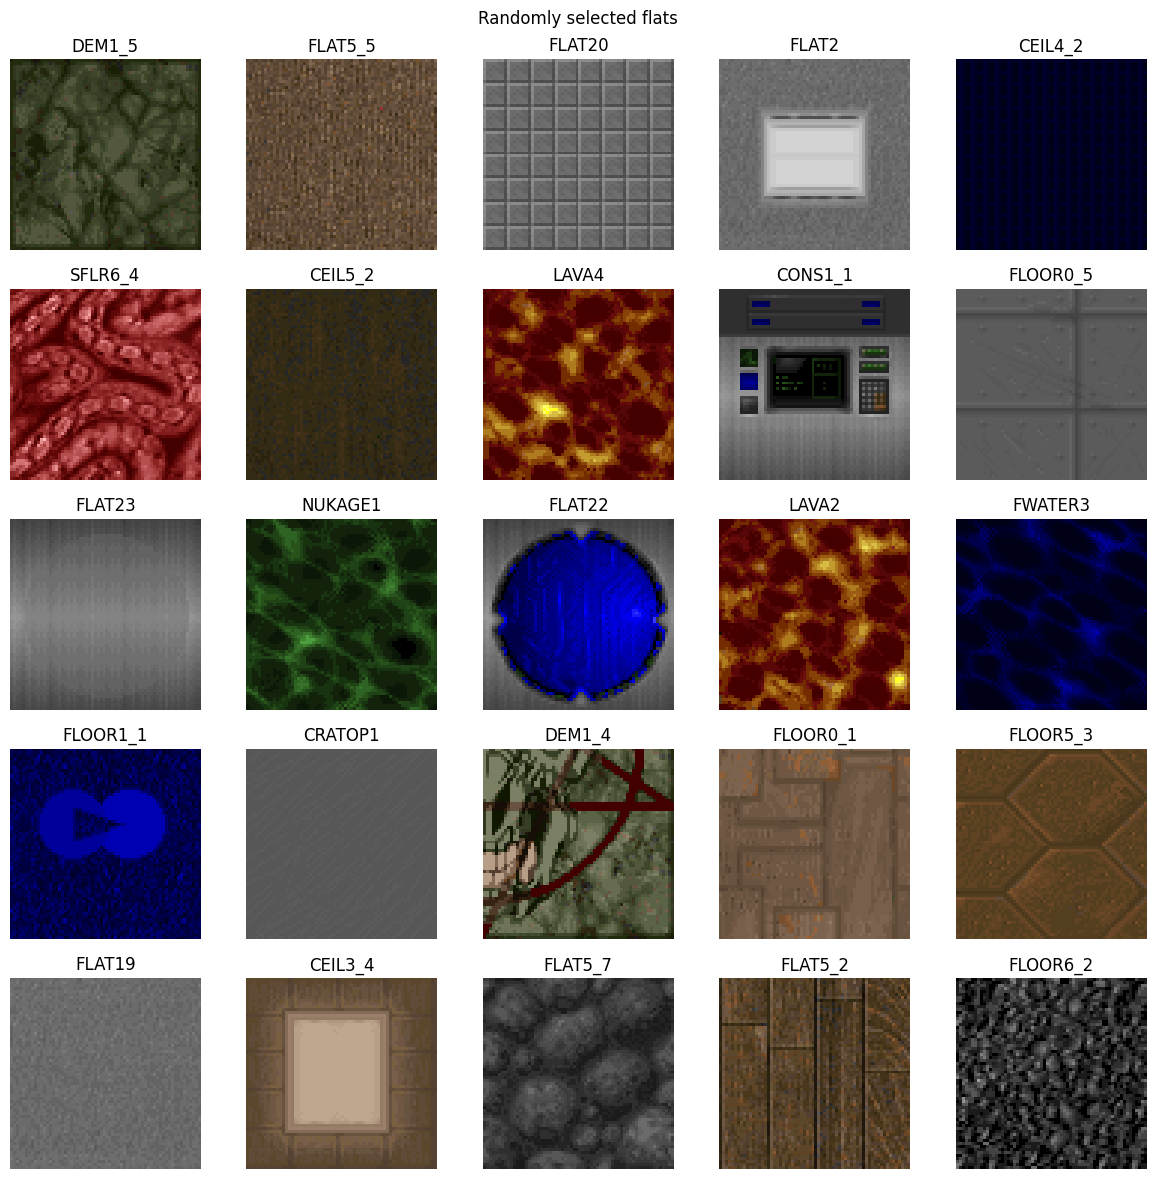

In [13]:
n_flats = 25
fig, ax = plt.subplots(5, 5, figsize=(12, 12))
ax = ax.ravel()

selected_flats = np.random.choice(wad.flats, size=n_flats, replace=False)

for i, flat_name in enumerate(selected_flats):

    viewer.draw_flat(flat_name, ax=ax[i])
    ax[i].set_title(flat_name)
    ax[i].axis("off")

fig.suptitle("Randomly selected flats")
fig.tight_layout(pad=1.2)

And display textures:

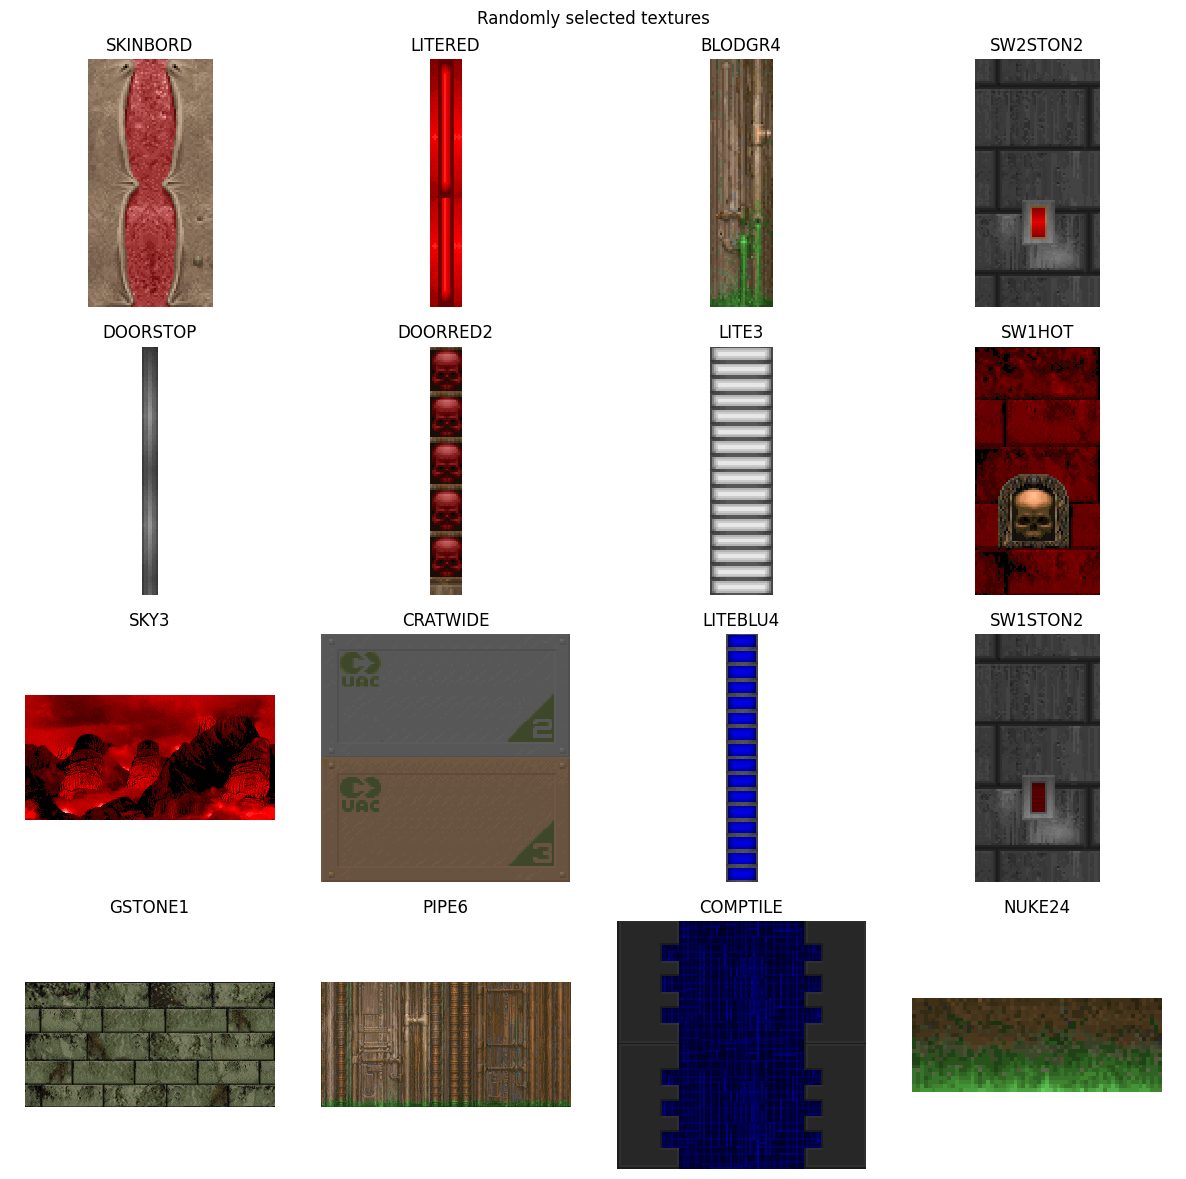

In [14]:
n_texs = 16
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
ax = ax.ravel()

selected_texs = np.random.choice(list(wad.textures.keys()), size=n_texs, replace=False)

for i, tex_name in enumerate(selected_texs):

    viewer.draw_tex(tex_name, ax=ax[i])
    ax[i].set_title(tex_name)
    ax[i].axis("off")

fig.suptitle("Randomly selected textures")
fig.tight_layout(pad=1.2)

The _draw_map_ methods will display the selected map:

2025-04-16 21:58:02.519 | INFO     | WADViewer:draw_map:139 - Plotted map E1M1.


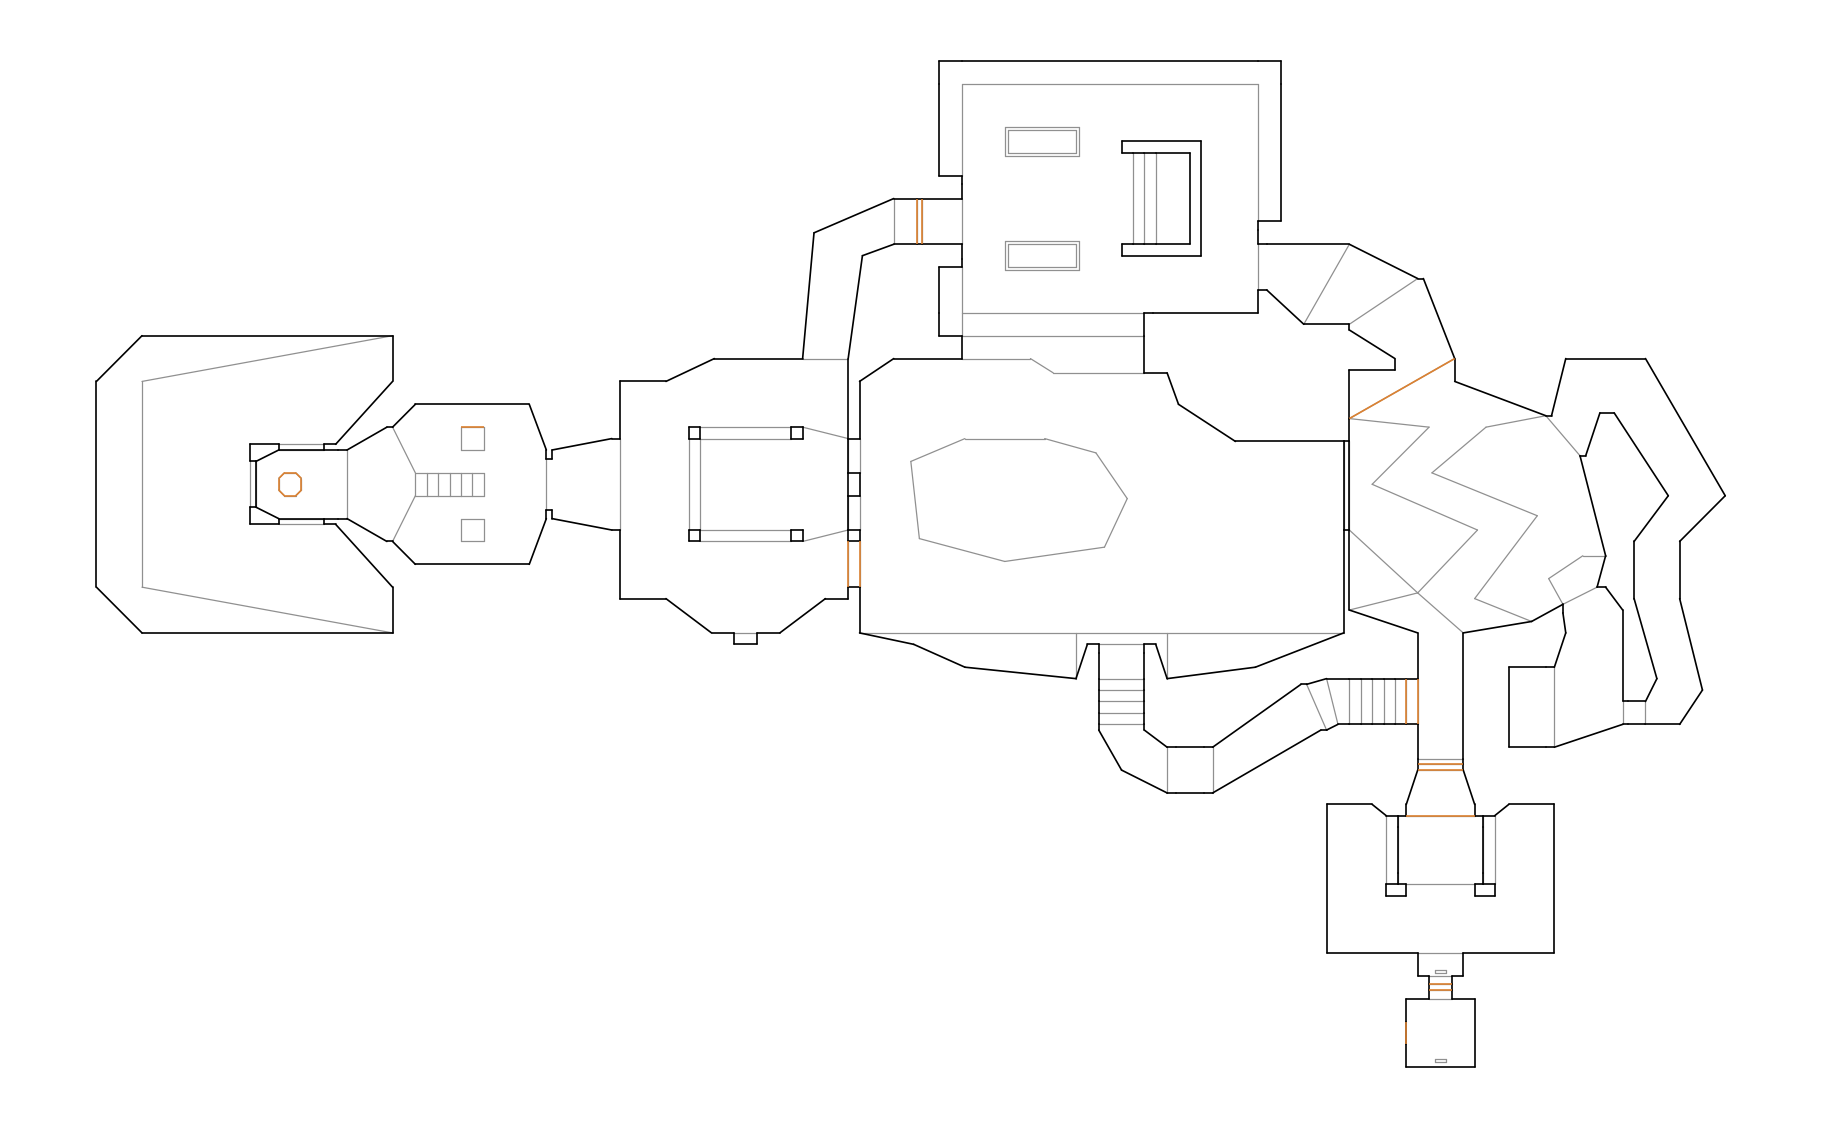

In [15]:
fig = viewer.draw_map('E1M1') 

It is built for accepting _axes_ objects as well:

2025-04-16 21:58:02.654 | INFO     | WADViewer:draw_map:139 - Plotted map E1M1.
2025-04-16 21:58:02.670 | INFO     | WADViewer:draw_map:139 - Plotted map E3M5.
2025-04-16 21:58:02.686 | INFO     | WADViewer:draw_map:139 - Plotted map E2M7.


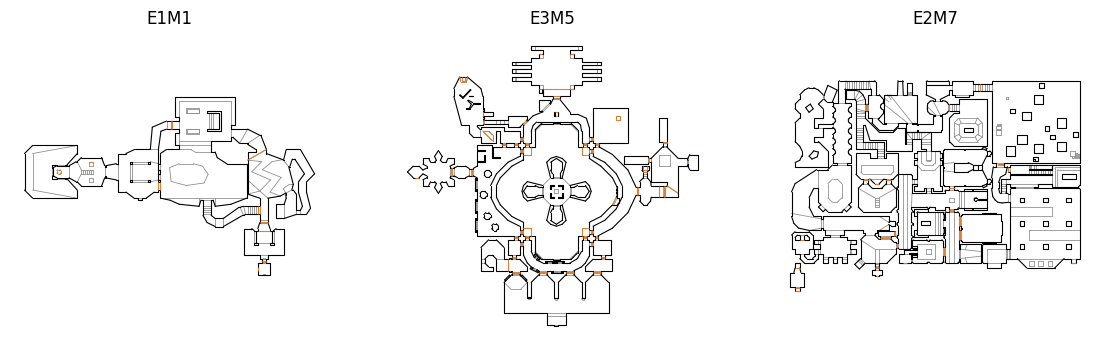

In [16]:
maps_to_show = ['E1M1', 'E3M5', 'E2M7']

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(14, 4))
ax = ax.ravel()

for i, map_name in enumerate(maps_to_show):
    viewer.draw_map(map_name, ax=ax[i])
    ax[i].set_title(map_name)

You can play with multiple palettes, displaying things or not, etc...
You can pass specific arguments to each Matplotlib LineCollection method, by using the prefix _block_, _twosided_, _things_, _secret_ or _special_ with '__' (Sklearn style):

2025-04-16 21:58:02.887 | INFO     | WADViewer:draw_map:139 - Plotted map E2M7.


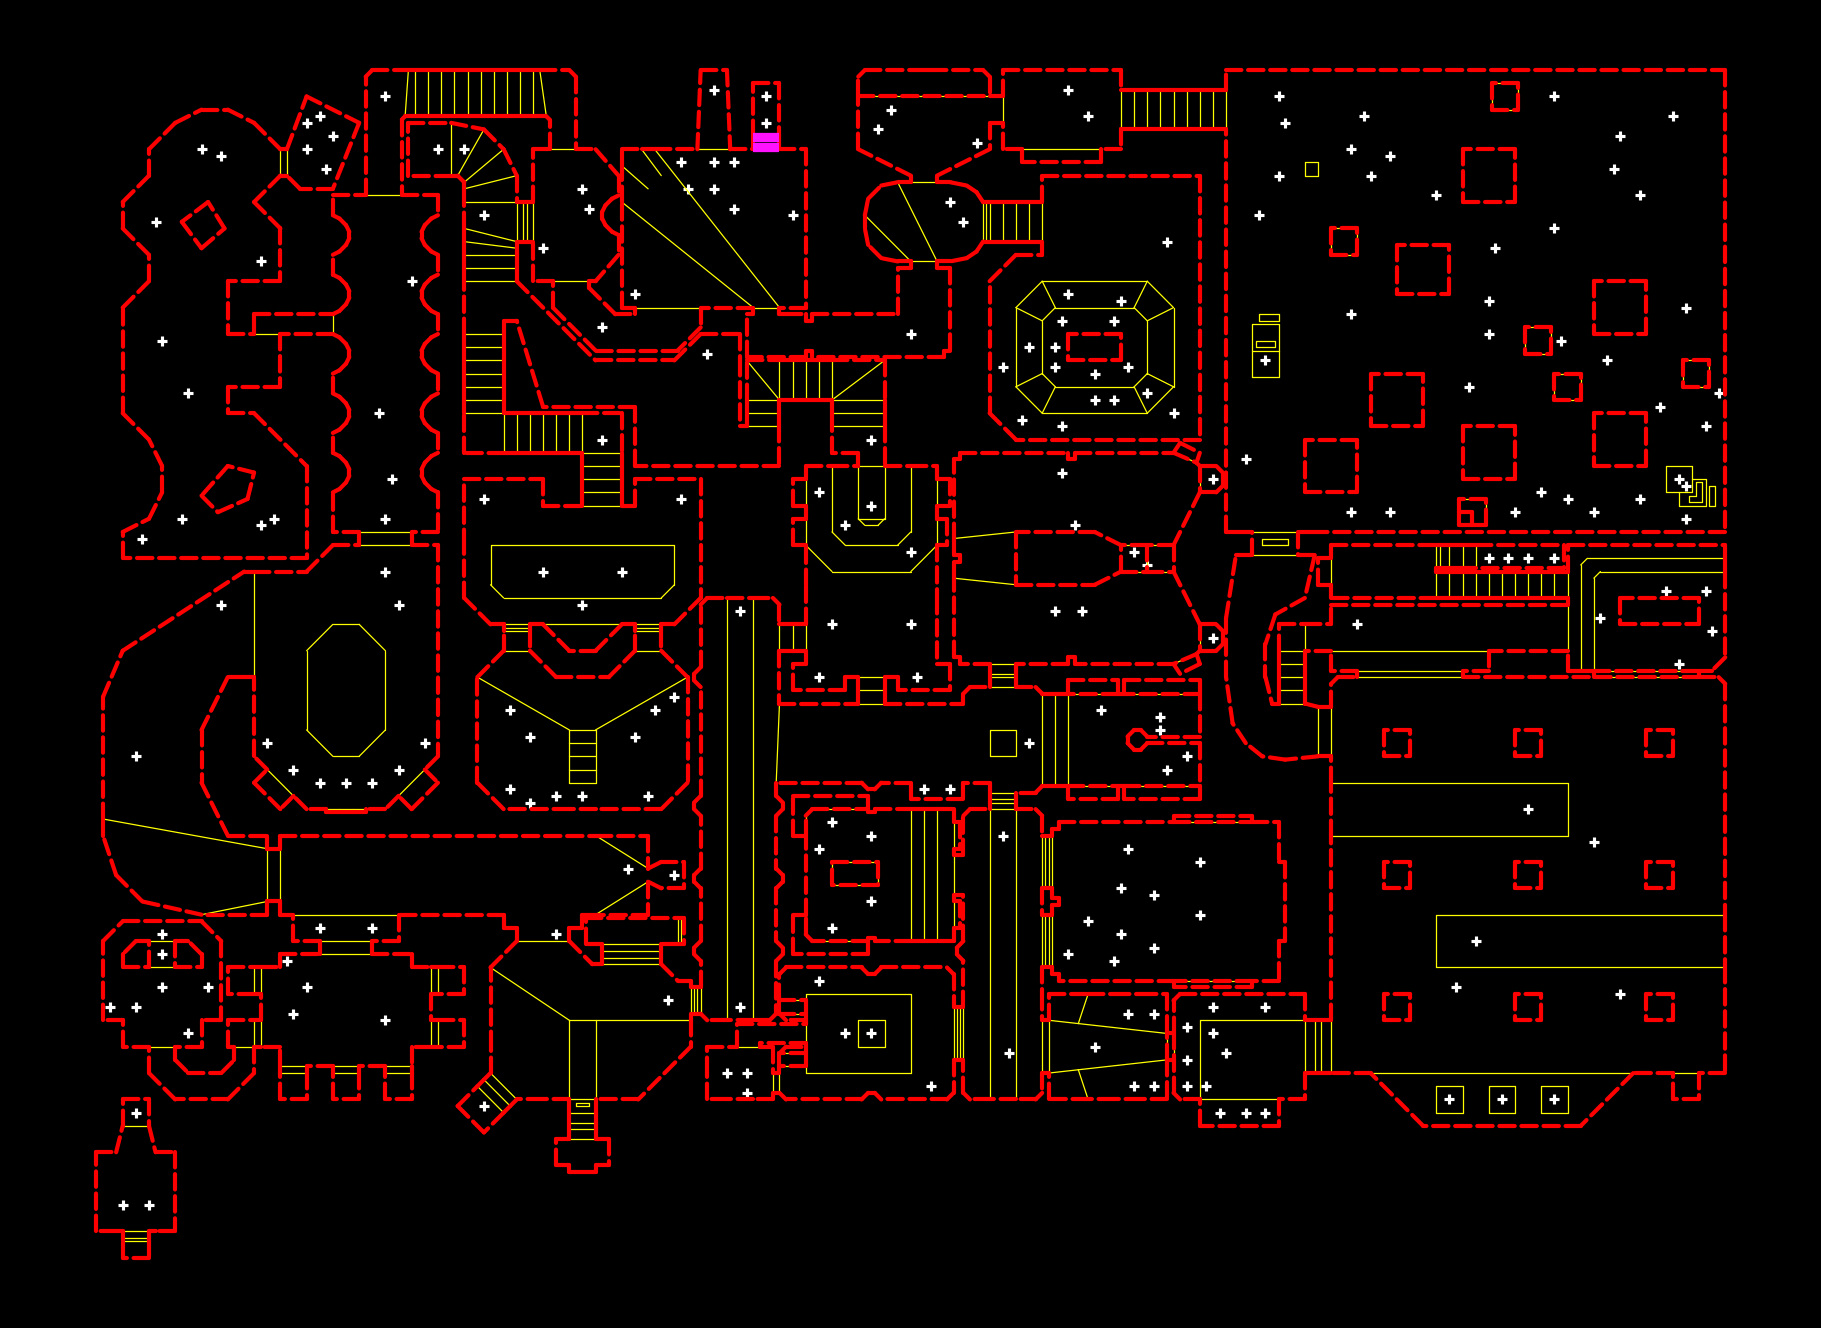

In [17]:
# This will be passed to the proper Matplotlib LineCollections drawing the different elements.
supp_params = {"block__linewidth": 2, "block__linestyle": "--", "things__s": 20, "secret__linewidth":3}

# Default values are palette='OMGIFOL', show_special=True, show_secret=False, show_things=False
fig = viewer.draw_map("E2M7", palette="DOOM", show_things=True, show_special=False, show_secret=True, **supp_params)

Musics can be exported as well and then transformed to midi format:

In [18]:
mus_path = 'output/D_E1M1.mus'
midi_path = 'output/D_E1M1.mid'

wad.export_music('D_E1M1', output_path=mus_path)

mus2mid = Mus2Mid(mus_path)
mus2mid.to_midi(midi_path)

2025-04-16 21:58:03.071 | INFO     | WADParser:export_music:360 - Saved music D_E1M1 to output/D_E1M1.mus.
2025-04-16 21:58:03.086 | INFO     | mus2mid:__init__:73 - File format detected: b'MUS\x1a'
2025-04-16 21:58:03.096 | INFO     | mus2mid:mus2mid:220 - Track size written: 23312 vs 17237
2025-04-16 21:58:03.096 | INFO     | mus2mid:to_midi:227 - Exported MUS output/D_E1M1.mus as a MIDI file to output/D_E1M1.mid.


And if you're on a Windows environment, played with a MIDIPlayer:

In [19]:
player = MIDIPlayer(midi_path)
player.play()

2025-04-16 21:58:03.103 | INFO     | WADPlayer:play_midi:37 - Playing MIDI file: output/D_E1M1.mid


2025-04-16 21:58:04.680 | INFO     | WADPlayer:play_midi:46 - Stopped by user
2025-04-16 21:58:04.680 | INFO     | WADPlayer:stop_midi:59 - Stopping MIDI playback


It can be stopped manually, or will stop at the end of the track.

In [20]:
player.stop()